# CIFAR10 with Transfer Learning

In [1]:
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model, Model
from keras.layers import Input, Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers.noise import GaussianNoise
from keras.layers.normalization import BatchNormalization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time, pickle
from keras.utils import to_categorical
%matplotlib inline

Using TensorFlow backend.


## 1. Load Data

In [2]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
y_train = y_train.reshape(y_train.shape[0])
y_test = y_test.reshape(y_test.shape[0])

nb_classes = 10
class_name = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck',
}

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'training samples')
print(X_test.shape[0], 'validation samples')

X_train shape: (50000, 32, 32, 3)
50000 training samples
10000 validation samples


## 2. Load Pre-trained Model

keras 提供了很方便的预训练模型库，可以通过 `keras.applications` 模块访问到。

- 在创建模型对象时，会自动检查本地是否已经有下载好的模型（h5格式），如果没有，会自动从Github上下载。（默认地址为 `~/.keras/models`）
- 每个模型都分两个版本：
    - 一种是文件名中带 `notop` 字段的模型，这种模型只含卷积层，不含全连接层，因此仅能用于特征识别，需要自己额外训练分类器。
        > `vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5`
    - 一种则是既带卷积层又带全连接层的完整模型版本，可以直接拿过来对新图像进行识别分类。
        > `vgg16_weights_tf_dim_ordering_tf_kernels.h5`

### 2.1 Load the Entire Model (CONV + FC)

随便找了一张几年前在新天鹅堡拍的照片，直接送入经过ImageNet数据集训练的VGG16完整模型。

可以看到，几乎不费吹灰之力，就能准确的预测出所属类别：`castle`。相当感人。

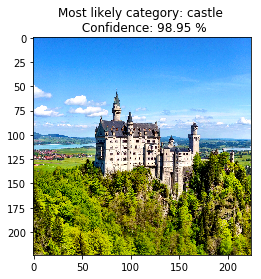

[[('n02980441', 'castle', 0.98945051),
  ('n03877845', 'palace', 0.0056559043),
  ('n03781244', 'monastery', 0.0041063223),
  ('n03028079', 'church', 0.00017413322),
  ('n09468604', 'valley', 0.00013395882)]]

In [5]:
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.preprocessing import image

base_model = VGG16(weights='imagenet')
img = image.load_img('castle.jpg', target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

y_pred = base_model.predict(x)
result = decode_predictions(y_pred, top=5)
plt.imshow(img, cmap='gray')
plt.title("Most likely category: %s \n Confidence: %.2f %%" % (result[0][0][1], result[0][0][2] * 100))
plt.show()
result

## 用ImageNet训练过的VGG16模型对我的Instagram照片库进行识别

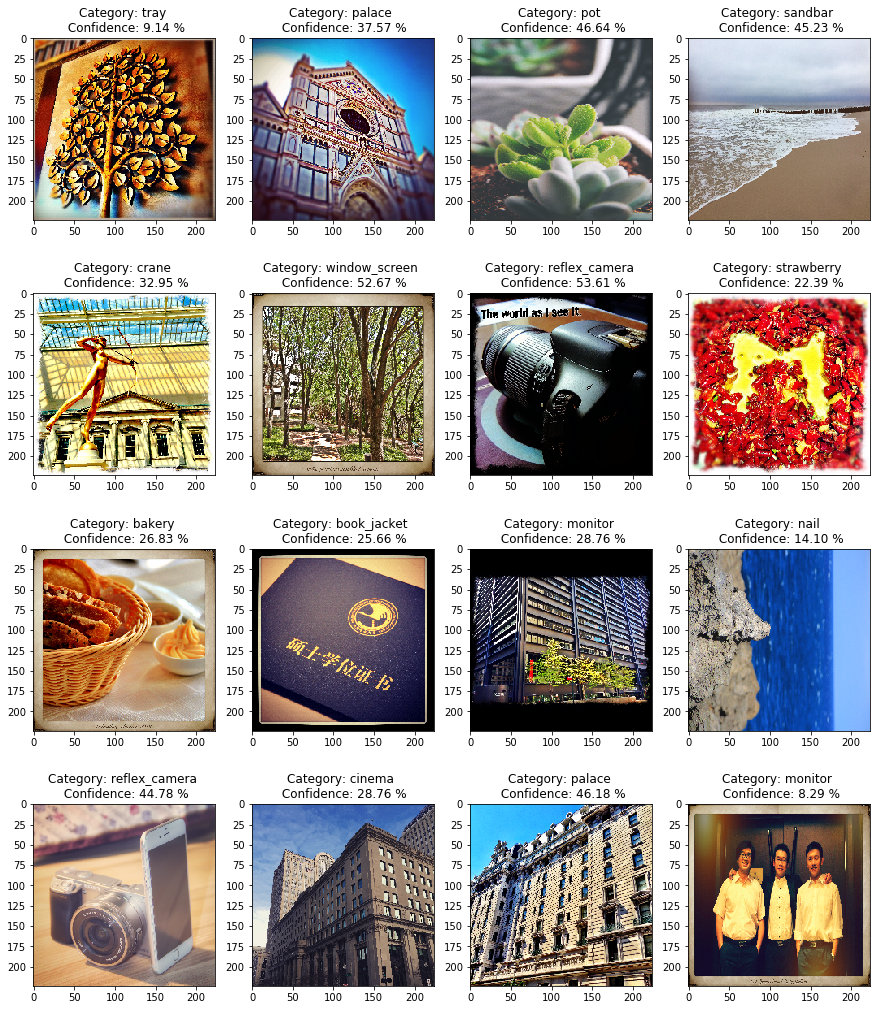

In [9]:
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.preprocessing import image
import os

base_model = VGG16(weights='imagenet')
instagram_path = 'D:\\PythonWorkSpace\\InstagramDB\\'
files = [filename for filename in os.listdir(instagram_path)]
n = 16
rand_id = np.random.choice(range(len(files)), n)
plt.figure(figsize=(15, 18))
for i in range(n):
    plt.subplot(4, 4, i+1)
    img = image.load_img(instagram_path + files[rand_id[i]], target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    y_pred = base_model.predict(x)
    result = decode_predictions(y_pred, top=5)
    plt.imshow(img, cmap='gray')
    plt.title("Category: %s \n Confidence: %.2f %%" % (result[0][0][1], result[0][0][2] * 100))
plt.show()

### 2.2 Pre-trained Model + New Classifier

虽然我们可以直接用Keras提供的预训练模型对新数据集进行预测，但是这仅适用于新数据集的图像类别是原数据集图像类别的子集的情况。一旦新的数据集有模型之前从未见过的图像类别，那么是不可能预测准确的。这时候就需要我们对模型最后部分的Classifier用新数据集进行训练才行了。